In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import math

## Расчёт погрешности по напряжению


### Первый делитель

Первый делитель не вносит в систему погрешности за счёт использования точных компонентов


## Делитель с цифровым резистором

Для наибольшего коэффициента деления используется максимальный номинал на резистивном делителе, таким образом при входном напряжении 100 В на выходе схеме делителя должно получится 0.5
0.5 = 100 \* (x / (10060 + x)) => x = 50.25


Схема рассчитывается как 0.5 = Uвх \* (50.55 / (Rд + 50.55))
тогда сопротивление цифрового резистора рассчитывается как Rд = 25.125 \* Uвх - 50.25


### Абсолютная погрешность

Абсолютная величина:
Uд = Uвх \* (50.55 / (Rд + 50.55))

Абсолютная погрешность в таком случае будет равна
Uд = Uвх \* (50.55 / (Rд + Rdelta + 50.55))

Rdelta - погрешность квантования
Rdelta = Rmax / (2 ^ n)

// Тут идёт всё преобразование формулы

delta*Uдел = -2 * Rdelta / (25.125 \* Uвх + Rdelta)


### Расчёт основной аддитивной погрешности

In [3]:
# Доступные номиналы резистора
RESITANCES = np.linspace(start=10_060, stop=99, retstep=10_060 - 9961, num=256, dtype=np.int32)[0]

In [4]:
def r_delta(r_max: int, r_step: int):
    return r_max / np.power(2, r_step)


def delta_u_divider(u_input: float, delta: float):
    return np.abs((-2 * delta) / (25.125 * u_input + delta))

(1024, 1024)

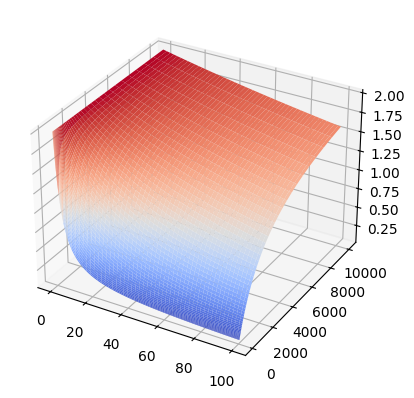

In [5]:
r_max = np.amax(RESITANCES)
x_layer = np.linspace(start=0, stop=100, num=1024)
X = np.array(x_layer)
y_layer = []
steps = np.linspace(start=0, stop=7, num=x_layer.size)
Y = np.array(r_delta(r_max, steps))

X, Y = np.meshgrid(X, Y)
Z = delta_u_divider(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True, shade=True, cmap=cm.coolwarm)
np.amax(Z)
Z.shape

На графике представлена плоскость, где по оси от 0 до 100 отображено значение входного напряжения, на оси Y от 0 до 10000 отображено значение Rdelta, что соответствует интегральной нелинейности. По оси Z отображено значение основной аддитивной погрешности квантования. Как видно из графика основную погрешность вносит погрешность квантования вызванная Rdelta, чем оно больше, тем больше погрешность.


### Расчёт дополонительной аддитивной погрешности погрешности цифрового резистора


В даташите к этой схеме указан температурный коэффициент делителя напряжения 0.6 LSB


0.19858808136135053

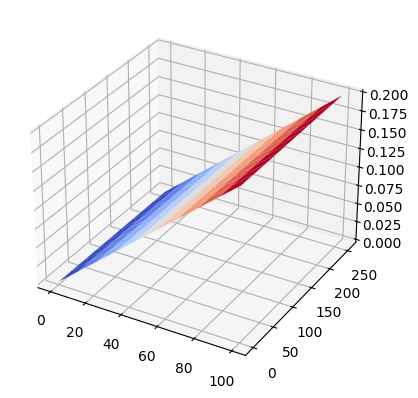

In [6]:
def ref_measure(u_input, r):
    return u_input * (50.55 / (r + 50.55))


def r_reference(pos: int):
    return RESITANCES[int(pos)]


def r_actual(pos: int, c):
    try:
        return RESITANCES[int(pos + math.ceil(0.6 * c))]
    except IndexError:
        return 9961


def actual_measure(u_input, r: int):
    return ref_measure(u_input, r)


# Для одного градуса
x_layer = np.linspace(start=0, stop=100, num=10)
X = np.array(x_layer)
Y = np.linspace(start=0, stop=255, num=x_layer.size)

X, Y = np.meshgrid(X, Y)
Z = []
for layer in Y:
    z_buf = []
    for pos in layer:
        z1_buf = []
        for x in x_layer:
            z1_buf.append(np.abs(actual_measure(x, r_actual(pos, 1)) - ref_measure(x, r_reference(pos))
                                 ) * 100)
        z_buf.append(np.array(z1_buf))
    Z.append(z_buf)
    if (np.array(Z).size == 100):
        break
Z = np.array(Z).reshape((10, 10))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True, shade=True, cmap=cm.coolwarm)
np.amax(Z)

На представленном графике показана абсолютная аддитивная погрешность с учётом температурный коэффициент делителя напряжения на один градус. Данный график показывает зависимость между входной величиной напряжения с смещения наименьшего бита данных для указателя делителя. Чем большее напряжение приложено к цифровому резистору, тем больше величина погрешности на каждом из номиналов резистора.


# Расчёт мультипликативной основной погрешнсти


Цифровой резистор не вносит основную мультипликативную погрешнсоть в систему


# Расчёт мультипликативной дополнительной погрешности

Резистор имеет температурный коэффициент сопротивления равный 45 ppm


/tmp/ipykernel_91944/1204519703.py:14: RuntimeWarning: invalid value encountered in divide
  return np.abs(actual_measure(u_input, r) - ref_measure(u_input, r)) / ref_measure(u_input, r)


nan

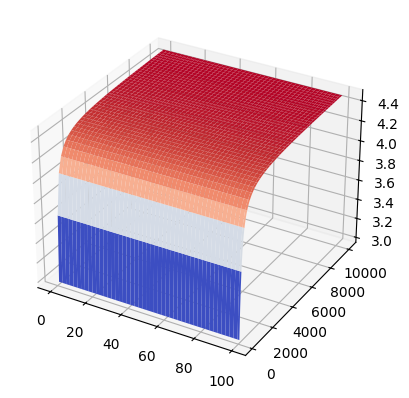

In [7]:
r_temp_ppm = 45
r_temp = 45 * (1 / (10 ** 6))


def ref_measure(u_input, r):
    return u_input * (50.55 / (r + 50.55))


def actual_measure(u_input, r: int):
    return ref_measure(u_input, r * (1 + r_temp))


def relative_mesure(u_input, r):
    return np.abs(actual_measure(u_input, r) - ref_measure(u_input, r)) / ref_measure(u_input, r)


# Для одного градуса
x_layer = np.linspace(start=0, stop=100, num=512)
X = np.array(x_layer)
Y = RESITANCES

X, Y = np.meshgrid(X, Y)
Z = relative_mesure(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True, shade=True, cmap=cm.coolwarm)
np.amax(Z)

Мультипликативная относительная дополнительная погрешности представлена на графике. На нём отчётливо видна зависимость между номиналом резистора и относительной погрешностью. Изменение происходит скачкобразно от 0 до 2000 Ом по оси сопротивлений, после чего равномерно увеличивается с 0.77 до 0.79


## Расчёт операционного усилителя


### Основная аддитивная

Offset Voltage (A Grade) = 0.1

U смещение по температуре = 0.1 \* (10 ^ -6)

Noise Voltage Peek To Peek (поэтому делим на два) = 2.4

U погрешность по шуму = 2.4 / 2 \* (10 \* -6)

### Дополнительная аддитивная

Offset Voltage Drift (A Grade) = 5

U погрешность по смещению сигнала = 5 * (10 ^ -6) B / *C


### Мультипликативная основная

Ку = 1

К вн дб = 96 дБ

К вн = 10 ^ (65 / 20) = 1178.27

δ коу = Kу / Kвн = (1 / 1178.27) \* 100 = 0.084870191 %

### Мультипликативная дополнительная

δ ку т = 4⸱ _ (10 ^ -3) / 2 _ 100 = 0.2 %

Отсальные мультипликативные погрешности малы, поэтому ими пренебрегаем


## Расчёт АЦП


### Расчёт основной аддитивной погрешности

Umax = 1 V

γ adc = 1 V / 2 ^ 8 \* 100 = 0.390625 %


### Расчёт основной мультипликативной погрешности

INL = 1.25 ppm

δ = 1.25 \* (10 ^ -6) %


### Доп погрешности

Пренебрегаем